In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud, STOPWORDS


In [30]:
from google.colab import files
import pandas as pd, numpy as np
uploaded = files.upload()
df = pd.read_csv(list(uploaded.keys())[0])

Saving student_feedback.csv to student_feedback (2).csv
Saving Student_Satisfaction_Survey.csv to Student_Satisfaction_Survey (1).csv


In [31]:
rename_map = {
    "Student ID": "Student_ID",
    "Well versed with the subject": "Subject_Knowledge",
    "Explains concepts in an understandable way": "Concept_Clarity",
    "Use of presentations": "Presentations",
    "Degree of difficulty of assignments": "Assignment_Difficulty",
    "Solves doubts willingly": "Doubt_Solving",
    "Structuring of the course": "Course_Structure",
    "Provides support for students going above and beyond": "Extra_Support",
    "Course recommendation based on relevance": "Course_Recommendation"
}
df = df.rename(columns={k:v for k,v in rename_map.items() if k in df.columns})


In [32]:
# Identify likely rating columns: numeric + mostly values in 1..5
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# If numeric types are not set, try coercing everything except Student_ID/Comments:
if not num_cols:
    tmp = df.drop(columns=[c for c in ['Student_ID','Comments'] if c in df.columns], errors='ignore').copy()
    for c in tmp.columns:
        tmp[c] = pd.to_numeric(tmp[c], errors='coerce')
    df[tmp.columns] = tmp
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

exclude = {'Student_ID'}
rating_cols = [c for c in num_cols if c not in exclude]

# Keep only columns that mostly lie in [1,5]
def is_likert(series):
    s = series.dropna()
    return (s.ge(1) & s.le(5)).mean() >= 0.8

rating_cols = [c for c in rating_cols if is_likert(df[c])]
rating_cols


[]

In [34]:
# Drop the unwanted index column
df = df.drop(columns=['Unnamed: 0'])

# Define rating columns
rating_cols = ['Subject_Knowledge', 'Concept_Clarity', 'Presentations',
               'Assignment_Difficulty', 'Doubt_Solving', 'Course_Structure',
               'Extra_Support', 'Course_Recommendation']

# Now check stats
df[rating_cols].describe().T


,count,mean,std,min,25%,50%,75%,max
Subject_Knowledge,1001.0,7.497502,1.692998,5.0,6.0,8.0,9.0,10.0
Concept_Clarity,1001.0,6.081918,2.597168,2.0,4.0,6.0,8.0,10.0
Presentations,1001.0,5.942058,1.415853,4.0,5.0,6.0,7.0,8.0
Assignment_Difficulty,1001.0,5.430569,2.869046,1.0,3.0,5.0,8.0,10.0
Doubt_Solving,1001.0,5.474525,2.874648,1.0,3.0,6.0,8.0,10.0
Course_Structure,1001.0,5.636364,2.920212,1.0,3.0,6.0,8.0,10.0
Extra_Support,1001.0,5.662338,2.891690,1.0,3.0,6.0,8.0,10.0
Course_Recommendation,1001.0,5.598402,2.886617,1.0,3.0,6.0,8.0,10.0


In [35]:
print(df[rating_cols].describe().T)


                        count      mean       std  min  25%  50%  75%   max
Subject_Knowledge      1001.0  7.497502  1.692998  5.0  6.0  8.0  9.0  10.0
Concept_Clarity        1001.0  6.081918  2.597168  2.0  4.0  6.0  8.0  10.0
Presentations          1001.0  5.942058  1.415853  4.0  5.0  6.0  7.0   8.0
Assignment_Difficulty  1001.0  5.430569  2.869046  1.0  3.0  5.0  8.0  10.0
Doubt_Solving          1001.0  5.474525  2.874648  1.0  3.0  6.0  8.0  10.0
Course_Structure       1001.0  5.636364  2.920212  1.0  3.0  6.0  8.0  10.0
Extra_Support          1001.0  5.662338  2.891690  1.0  3.0  6.0  8.0  10.0
Course_Recommendation  1001.0  5.598402  2.886617  1.0  3.0  6.0  8.0  10.0


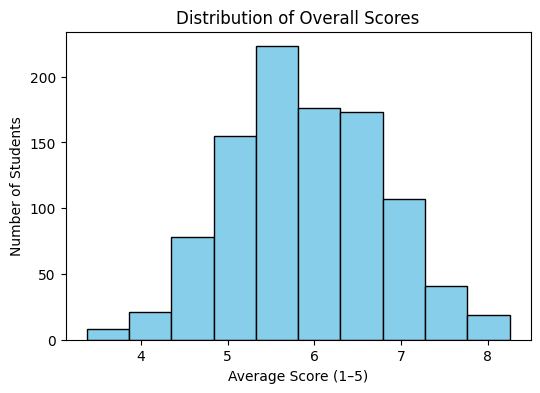

In [36]:
import matplotlib.pyplot as plt

df['Overall_Score'] = df[rating_cols].mean(axis=1)

plt.figure(figsize=(6,4))
df['Overall_Score'].plot(kind='hist', bins=10, color='skyblue', edgecolor='black')
plt.title("Distribution of Overall Scores")
plt.xlabel("Average Score (1–5)")
plt.ylabel("Number of Students")
plt.show()


/tmp/ipython-input-85141845.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_ratings.values, y=avg_ratings.index, palette="viridis")


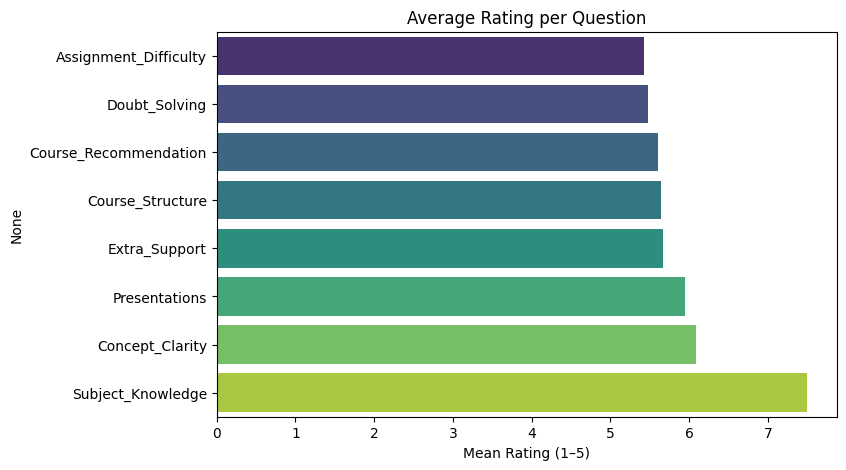

In [37]:
import seaborn as sns

avg_ratings = df[rating_cols].mean().sort_values()

plt.figure(figsize=(8,5))
sns.barplot(x=avg_ratings.values, y=avg_ratings.index, palette="viridis")
plt.title("Average Rating per Question")
plt.xlabel("Mean Rating (1–5)")
plt.show()


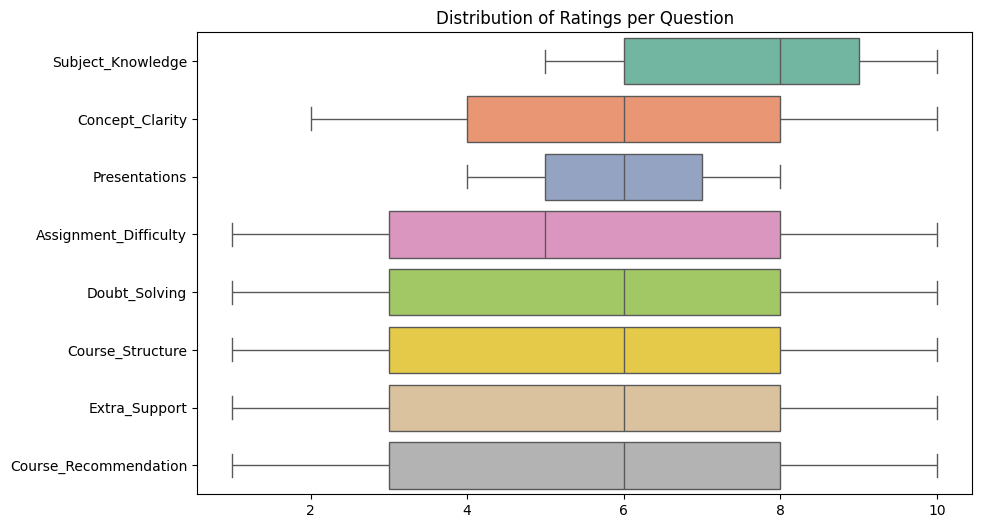

In [38]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df[rating_cols], orient="h", palette="Set2")
plt.title("Distribution of Ratings per Question")
plt.show()


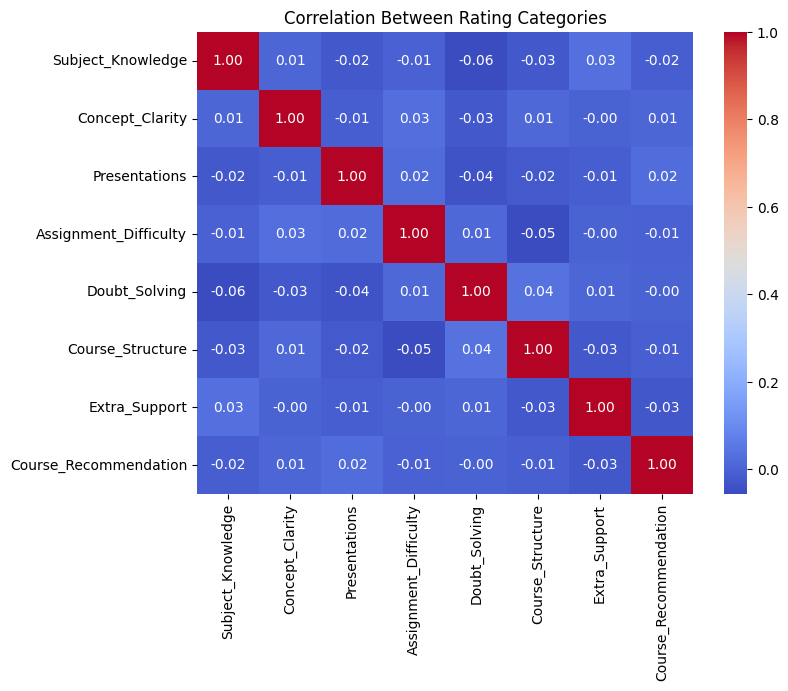

In [39]:
plt.figure(figsize=(8,6))
sns.heatmap(df[rating_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Rating Categories")
plt.show()


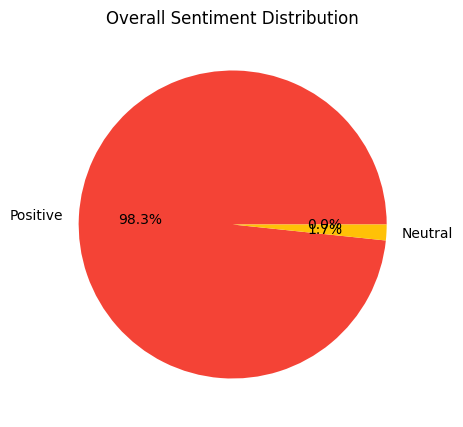

In [40]:
df['Sentiment'] = pd.cut(df['Overall_Score'],
                         bins=[-1,2.5,3.5,5.1],
                         labels=['Negative','Neutral','Positive'])

sent_counts = df['Sentiment'].value_counts()

plt.figure(figsize=(5,5))
sent_counts.plot(kind='pie', autopct='%1.1f%%', colors=["#F44336","#FFC107","#4CAF50"])
plt.title("Overall Sentiment Distribution")
plt.ylabel("")
plt.show()


In [41]:
print("Top 3 Highest Rated Questions:")
print(avg_ratings.tail(3))

print("\nBottom 3 Lowest Rated Questions:")
print(avg_ratings.head(3))


Top 3 Highest Rated Questions:
Presentations        5.942058
Concept_Clarity      6.081918
Subject_Knowledge    7.497502
dtype: float64

Bottom 3 Lowest Rated Questions:
Assignment_Difficulty    5.430569
Doubt_Solving            5.474525
Course_Recommendation    5.598402
dtype: float64


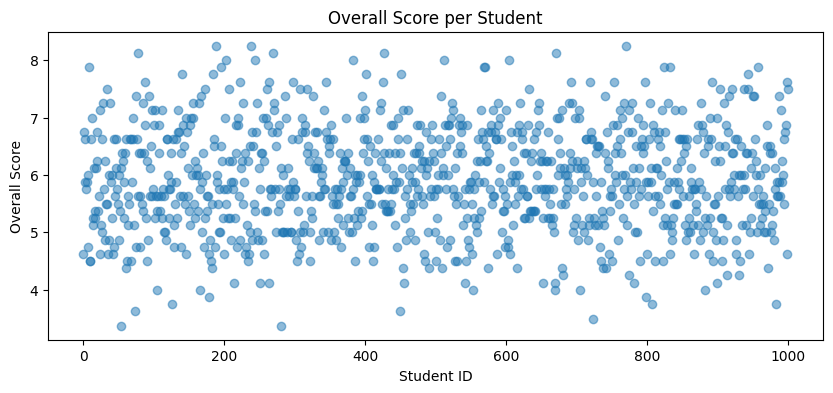

In [42]:
plt.figure(figsize=(10,4))
plt.plot(df['Student_ID'], df['Overall_Score'], marker="o", linestyle="", alpha=0.5)
plt.title("Overall Score per Student")
plt.xlabel("Student ID")
plt.ylabel("Overall Score")
plt.show()
